# __Image Classification Using Waste Items Dataset__
- RealWaste dataset was created as apart of an honors thesis researching how convolution neural networks could perform on authentic waste material when trained on objects in pure and unadulterated forms, when compared to training via real waste items.
- Class labels: Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, and Vegetation

### Step1: Importing Required Libraries

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from keras.preprocessing import image




### Step2: Download the dataset

In [3]:
data_dir='/kaggle/input/realwaste/realwaste-main/RealWaste'

In [4]:
from PIL import Image
images_dict = {
    'image1': Image.open('/kaggle/input/realwaste/realwaste-main/RealWaste/Paper/Paper_10.jpg'),
    'image2': Image.open('/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_1.jpg'),
}

In [5]:
for key, image in images_dict.items():
    width, height = image.size
    print(f"Size of {key}: width={width}, height={height}")

Size of image1: width=524, height=524
Size of image2: width=524, height=524


In [6]:
from PIL import Image
import os

# Define the directory containing your images and the target size
data_dir = '/kaggle/input/realwaste/realwaste-main/RealWaste'
target_size = (224, 224)  # Example target size, adjust as needed
output_dir = '/kaggle/working/resized_images'  # Directory to save resized images

# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Iterate over files in the data directory
for file_name in os.listdir(data_dir):
    file_path = os.path.join(data_dir, file_name)

    # Check if it's a file (and optionally check if it's an image)
    if os.path.isfile(file_path):
        try:
            # Open and resize the image
            with Image.open(file_path) as img:
                resized_image = img.resize(target_size, Image.ANTIALIAS)

                # Save the resized image to the output directory
                output_path = os.path.join(output_dir, file_name)
                resized_image.save(output_path)
                print(f"Resized and saved {file_name} to {output_path}")
        except Exception as e:
            print(f"Could not process {file_name}: {e}")

print("Image resizing completed.")


Image resizing completed.


### Step3:Load data using a Keras utility

In [7]:
batch_size = 32
img_height =224
img_width = 224

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4752 files belonging to 9 classes.
Using 3802 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4752 files belonging to 9 classes.
Using 950 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


### Step4: Visualize the data

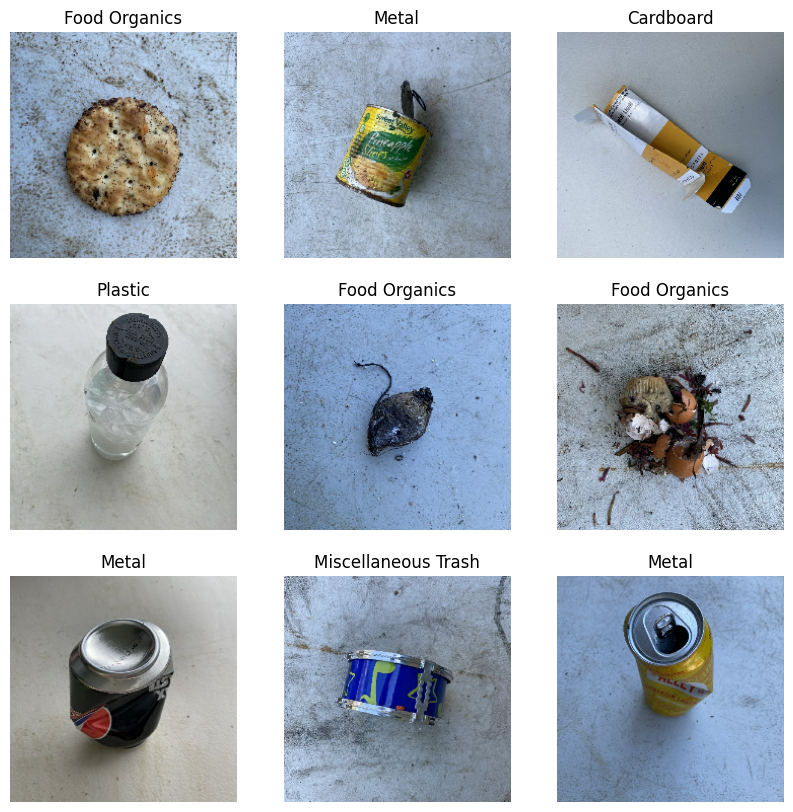

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Step6: Configure the dataset for performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Step7:Standardize the data

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.98940533


### Step14:Model Improvement Using Dropout,EarlyStopping,BatchNormalization


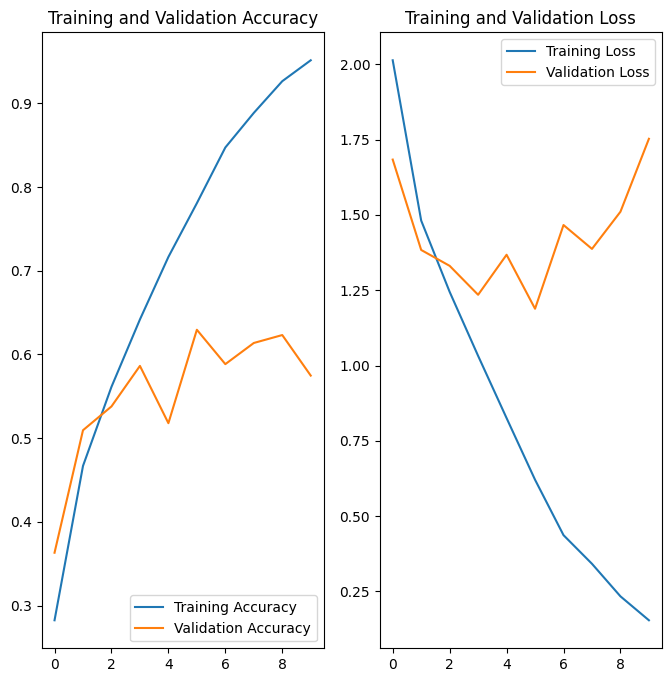



 The plots above from previous notebook image_classification.ipynb,as we can see the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable of **overfitting** which I will fix it by using dropout,early stopping,batch normalization

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True  )

In [20]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),  # Add Batch Normalization
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),  # Add Batch Normalization
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),  # Add Batch Normalization
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Step15: Compile and train the model

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,447,849 (24.60 MB)

 Trainable params: 6,447,625 (24.60 MB)

 Non-trainable params: 224 (896.00 B)

In [23]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.3488 - loss: 5.8568 - val_accuracy: 0.1474 - val_loss: 15.1435
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.4256 - loss: 1.5934 - val_accuracy: 0.1021 - val_loss: 18.2560
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.5243 - loss: 1.3838 - val_accuracy: 0.1895 - val_loss: 10.6632
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.5843 - loss: 1.1846 - val_accuracy: 0.3284 - val_loss: 4.2873
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.6186 - loss: 1.0472 - val_accuracy: 0.4526 - val_loss: 1.9296
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - accuracy: 0.6700 - loss: 0.8852 - val_accuracy: 0.3274 - val_loss: 3.4014
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.7038 - loss: 0.7864 - val_accuracy: 0.5695 - val_loss: 1.4088
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.7487 - loss: 0.6927 - val_a

### Step16:Visualize training results

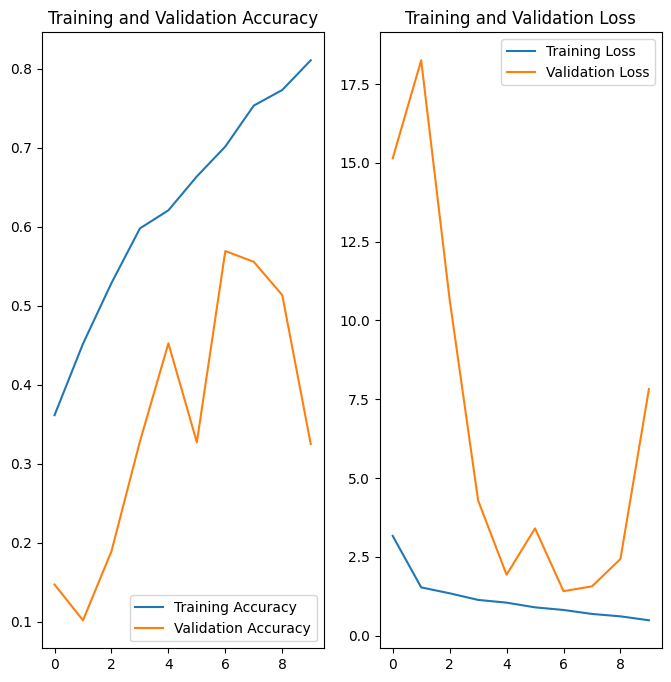

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()